# Import/Read Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy
import re, string
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob # sentiment analysis
from sklearn.decomposition import NMF # topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer # document-term matrix creation

%matplotlib inline

In [2]:
# Set some default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('darkgrid')
plt.rc('figure', facecolor='#00000000', figsize=(10,8))
plt.rc('font', size=12)

In [3]:
df = pd.read_csv('/Users/abhi/Downloads/TeslaData.csv')
df.head() 

,MsgID,Timestamp,Author,ThreadID,ThreadTitle,MsgBody,ReplyTo,Type,Unnamed: 8
0,'rtabau','2021-12-31 20:20:09','4couui6h','rtabau','Tesla drift','','','1',NaN
1,'hqrjth2','2021-12-31 20:20:09','6l4z3','rtabau','Tesla drift','If help is needed use our stickied support th...,'t3_rtabau','2',NaN
2,'rt9ph9','2021-12-31 19:44:49','2dwzknif','rt9ph9','And the rocket’s red glare the bomb bursting ...,'','','1',NaN
3,'hqrfop4','2021-12-31 19:44:50','6l4z3','rt9ph9','And the rocket’s red glare the bomb bursting ...,'If help is needed use our stickied support th...,'t3_rt9ph9','2',NaN
4,'hqrfpxe','2021-12-31 19:45:07','2dwzknif','rt9ph9','And the rocket’s red glare the bomb bursting ...,'Photo credit @rkaplan1 on Twitter','t3_rt9ph9','2',NaN


# Explorator Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23676 entries, 0 to 23675
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MsgID        23676 non-null  object 
 1   Timestamp    23533 non-null  object 
 2   Author       23533 non-null  object 
 3   ThreadID     23533 non-null  object 
 4   ThreadTitle  23533 non-null  object 
 5   MsgBody      23533 non-null  object 
 6   ReplyTo      23533 non-null  object 
 7   Type         23533 non-null  object 
 8   Unnamed: 8   0 non-null      float64
dtypes: float64(1), object(8)
memory usage: 1.6+ MB


In [5]:
df.drop(columns=['MsgID', 'ThreadID', 'ReplyTo', 'Author'], inplace=True)
df.head()

,Timestamp,ThreadTitle,MsgBody,Type,Unnamed: 8
0,'2021-12-31 20:20:09','Tesla drift','','1',NaN
1,'2021-12-31 20:20:09','Tesla drift','If help is needed use our stickied support th...,'2',NaN
2,'2021-12-31 19:44:49','And the rocket’s red glare the bomb bursting ...,'','1',NaN
3,'2021-12-31 19:44:50','And the rocket’s red glare the bomb bursting ...,'If help is needed use our stickied support th...,'2',NaN
4,'2021-12-31 19:45:07','And the rocket’s red glare the bomb bursting ...,'Photo credit @rkaplan1 on Twitter','2',NaN


In [6]:
df['Timestamp'] =  pd.to_datetime(df['Timestamp'], infer_datetime_format=True, format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23676 entries, 0 to 23675
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    23533 non-null  datetime64[ns]
 1   ThreadTitle  23533 non-null  object        
 2   MsgBody      23533 non-null  object        
 3   Type         23533 non-null  object        
 4   Unnamed: 8   0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 925.0+ KB


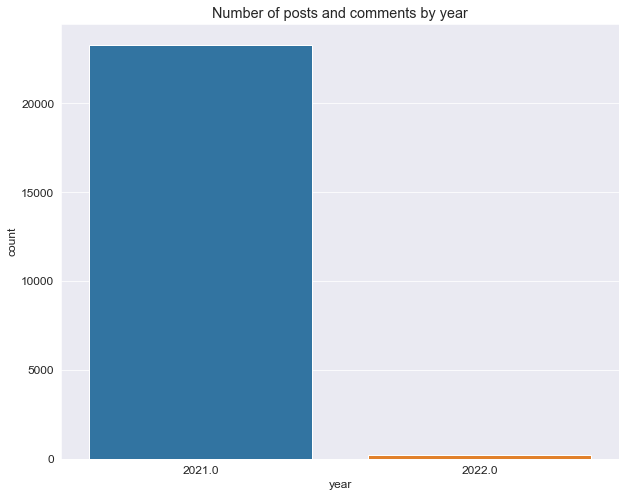

In [7]:
# Extract year and month of the data
df['year'] = pd.DatetimeIndex(df['Timestamp']).year
df['month'] = pd.DatetimeIndex(df['Timestamp']).month

# Create a count plot
sns.countplot(x='year', data=df)
plt.title('Number of posts and comments by year')
plt.show()

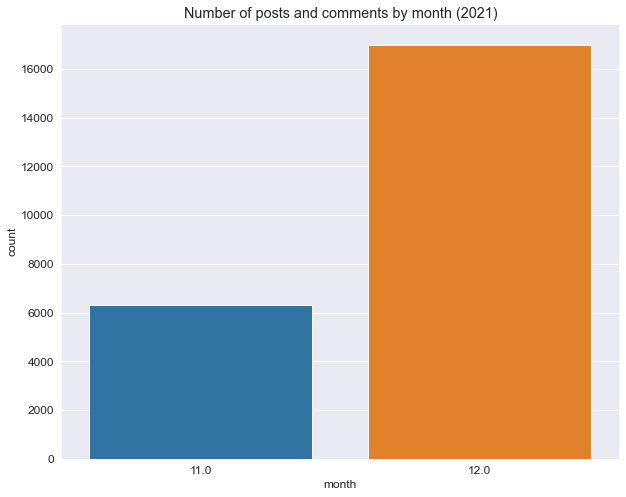

In [8]:
sns.countplot(x='month', data=df.loc[df['year'] == 2021])
plt.title('Number of posts and comments by month (2021)')
plt.show()

# Text Preprocessing

In [9]:
def preprocess(sentence):
    """
    Convert text to lowercase
    Remove website link, special characters, newline character and extra spaces
    """
    sentence = str(sentence)
    sentence = sentence.lower()
    rem_spe_chr = re.sub(r"[-()\"#/@;:<>\[\]{}`+=~|.!?,]", "", sentence)
    rem_url = re.sub(r'http\S+', '', rem_spe_chr)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_num = re.sub(r'[0-9]+', '', rem_nl)
    rem_space = re.sub(r'\s\s+', ' ', rem_num)
    return rem_space

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Add stopwords
STOP_WORDS.update(['for', 'the', 'and', 'it', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'find', 'read', 'point','a', 'an', 'the', 'and', 'it', 'for', 'or', 'but', 'in', 'my', 
                   'your', 'our', 'their','I'])

def lemmatize(sentence):
    # Create Doc object and disable components we don't need (for efficiency)
    doc = nlp(sentence, disable=['ner', 'parser'])

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    alp_lemmas = [lemma for lemma in lemmas 
                  if lemma.isalpha() and lemma not in STOP_WORDS] 

    return ' '.join(alp_lemmas)

In [10]:
# Create another dataframe that contains the cleaned text
df_cleaned = df.copy()

# Preprocess and lemmatize the title (non-comment) and body
df_cleaned.loc[df_cleaned['ThreadTitle'] != 'Comment', 'ThreadTitle'] = df_cleaned.loc[df_cleaned['ThreadTitle'] != 'Comment', 'ThreadTitle'].apply(preprocess).apply(lemmatize)
df_cleaned.loc[~df_cleaned['MsgBody'].isnull(), 'MsgBody'] = df_cleaned.loc[~df_cleaned['MsgBody'].isnull(), 'MsgBody'].apply(preprocess).apply(lemmatize)
df_cleaned.tail()

,Timestamp,ThreadTitle,MsgBody,Type,Unnamed: 8,year,month
23671,2021-11-19 10:03:04,tesla quadruple supercharger price overnight,specially design way charge extreme speed road...,'2',NaN,2021.0,11.0
23672,2021-11-18 22:08:06,tesla quadruple supercharger price overnight,blow mind charger supercharger road trip,'2',NaN,2021.0,11.0
23673,2021-11-18 22:34:46,tesla quadruple supercharger price overnight,selling tote parade free candy hand clearly ob...,'2',NaN,2021.0,11.0
23674,2021-11-19 13:53:59,tesla quadruple supercharger price overnight,specially design way charge extreme speed road...,'2',NaN,2021.0,11.0
23675,2021-11-19 08:32:00,tesla quadruple supercharger price overnight,stop rely primary source kind dumb complain,'2',NaN,2021.0,11.0


# Sentiment Analysis

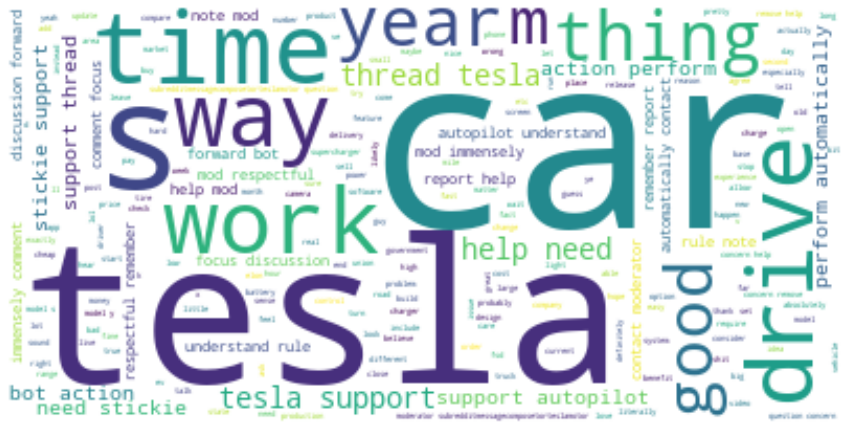

In [11]:
# Import the word cloud function  
from wordcloud import WordCloud

# Iterate through body column to join the text in all rows
body_words = ''
for sentence in df_cleaned.loc[~df_cleaned['MsgBody'].isnull(), 'MsgBody']:
    body_words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=200).generate(body_words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

#### The word cloud above shows the most common words but we cannot derive any real meaning or value so it would be best to use TextBlob next.

In [12]:
# Create columns for sentiment and subjectivity
df['sentiment'] = np.NaN
df['subjectivity'] = np.NaN

def basic_preprocess(sentence):
    """Perform basic preprocessing of text without removing special characters"""
    sentence = str(sentence)
    rem_url = re.sub(r'http\S+', '', sentence)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_space = re.sub(r'\s\s+', ' ', rem_nl)
    return rem_space

def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value"""
    if sentence != '':
      score = TextBlob(sentence).sentiment.polarity
      if score < 0:
          return "Negative"
      elif score == 0:
          return "Neutral"
      else:
          return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text"""
    return TextBlob(sentence).sentiment.subjectivity

In [13]:
# Apply basic preprocessing for body text
df.loc[~df['MsgBody'].isnull(), 'MsgBody'] = df.loc[~df['MsgBody'].isnull(), 'MsgBody'].apply(basic_preprocess)

# Populate the sentiment and subjectivity
df.loc[~df['MsgBody'].isnull(), 'sentiment'] = df.loc[~df['MsgBody'].isnull(), 'MsgBody'].apply(get_sentiment)
df.loc[~df['MsgBody'].isnull(), 'subjectivity'] = df.loc[~df['MsgBody'].isnull(), 'MsgBody'].apply(get_subjectivity)

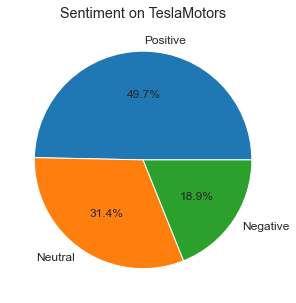

In [14]:
# Create a pie chart
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(df['sentiment'].value_counts(normalize=True), labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%')
ax.set_title('Sentiment on TeslaMotors')
plt.show();

#### Based on the pie chart above we can see that almost 50% of text sentiments are seen to be positive, ~19% are negative and ~31% are neutral. Below we can see the use of TextBlob in classifying for positive, neutral and negative sentiments.

In [15]:
list(df.loc[df['sentiment'] == 'Positive', 'MsgBody'].sample(10))

["'lol. I’ve worked with this stuff on a student level competition car for the past three years and you’re absolutely right. Can’t believe he linked a paper that proves him wrong.'",
 "'You need to look into Tesla’s long-term goals. It sees itself as quite a large stakeholder in the future rideshare market.'",
 "'Nice!'",
 "'Ive driven FSD Beta: Its awesome in surburban neighborhoods. Its so surreal. When it comes to super dense cities it struggles a bit dealing with pesky unpredictable humans but its getting A LOT better.'",
 "'So much nicer than my old power wheels. Way more expensive too.'",
 "'Its been required on all new cars since May 2018 This law makes them standard but it doesnt apply to cars sold before the date. The law was passed years earlier so auto manufacturers had been putting in rear cameras for a while already. Eventually those cars without a rear camera will disappear off the roads.'",
 "'why would he need to have cabin overheat protection on if regular ICE chips wo

In [16]:
list(df.loc[df['sentiment'] == 'Neutral', 'MsgBody'].sample(10))

["'I bought one here in texas without jumping through any hoops....'",
 "'Shaggin wagon?'",
 "'Huh. This looks like a personal experience to me. I thought those weren’t allowed?'",
 "'[removed]'",
 "'12/9 😁'",
 "'Anecdotal'",
 "'People are also not having problems. But eh whatever.'",
 "'[removed]'",
 "'Wishful thinking I know. But defamation is legit used in court and they ***could*** do something similar.'",
 "'Try the video that wasnt compressed to hell by Twitter: "]

In [17]:
list(df.loc[df['sentiment'] == 'Negative', 'MsgBody'].sample(10))

["'Thats a long time to keep book on a grudge.'",
 "'They only get covered by the mission if they dont snub the mission. Going with CCS charging when they had no competitive reason not to go Tesla supercharging was a slight intentional or otherwise. That was my one killer issue that broke me for a rivian purchase over model Y.'",
 "'It should cost Tesla more to make but they’ll probably sell similar to MIC due to no shipping Lower margins but MIC margins are insane so I’m not surprised'",
 "'That’s not how this works or *should* work. Other OEMs have AP-like and/or equivalent systems out there without having their customers beta test it. It’s one thing to beta test FSD. It’s another to have us be testing cruise control…'",
 "'The Tesla Fremont factory is a former GM assembly plant. Maybe Tesla should stream the movie Who Killed the Electric Car.'",
 "'Aside from ionity which costs your left kidney theres nothing else remotely comparable. Its a desolate wasteland here.'",
 "'Definitely 

In [18]:
df['subjectivity'].describe()

count    23533.000000
mean         0.385021
std          0.291858
min          0.000000
25%          0.000000
50%          0.433333
75%          0.600000
max          1.000000
Name: subjectivity, dtype: float64

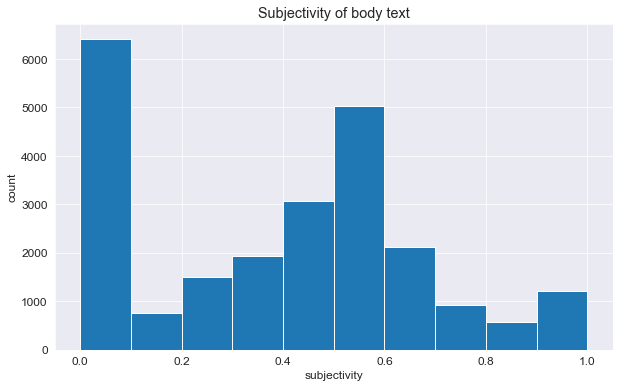

In [19]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

In [20]:
##df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

#### The above histogram represents the subjectivity of posts and comments.

# Topic Modeling

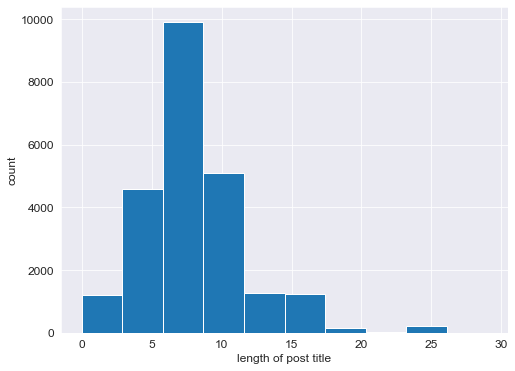

In [21]:
def count_words(string):
    """Count the number of words in each string"""
    words = string.split()
    return len(words)

# Extract posts with title (exclude comments)
df_with_title = df_cleaned[df_cleaned['ThreadTitle'] != 'Comment'].copy()

# Calculate the sentence length
df_with_title['title_word_count'] = df_with_title['ThreadTitle'].apply(count_words)

# Plot sentence length distribution
plt.figure(figsize=(8,6))
plt.hist(df_with_title['title_word_count'])
plt.xlabel('length of post title')
plt.ylabel('count')
plt.show();

#### The above graph indicates that the majority of post titles have somewhere between 5 to 10 words.

In [22]:
# Create tf-idf matrix - ignore terms that have a document frequency strictly higher than 95% and less than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=4,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_with_title['ThreadTitle'].values.astype(str))

print(tfidf.shape)

(23676, 1139)


In [23]:
# Fit NMF model to post titles
nmf = NMF(n_components=6, random_state=2).fit(tfidf)
nmf_output = nmf.fit_transform(tfidf)
print(nmf_output.shape)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


(23676, 6)


In [24]:
def get_topic_keywords(vectorizer, model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        # Find the indices of top n words with the highest weightage 
        top_keyword_locs = (-topic_weights).argsort()[:n_words]

        # Extract the keywords based on indices
        topic_keywords.append(keywords.take(top_keyword_locs))
    
    return topic_keywords

# Get the top 10 words for each topic
topic_keywords = get_topic_keywords(vectorizer=tfidf_vectorizer, model=nmf, n_words=10)   

# Display the topic and its top 10 keywords
for i in range(len(topic_keywords)):
    print("Topic {}: {}".format(i, ' '.join(topic_keywords[i])))

Topic 0: pass act senate need build musk elon bandwagon yoke american
Topic 1: regret spoiler new plaid small wrong right replace come way
Topic 2: model interruption hour repurpose wrecked zero house day battery run
Topic 3: highlight gms union employee worker elon musk factory arrest shoot
Topic 4: theoryit firsttime interface owner hook screw bad good year test
Topic 5: sell whistle cyberquad kid blow elon unit december china car


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# Get the index of the highest topic weightage
df_with_title['topic'] = nmf_output.argmax(axis=1)
df_with_title.head()

,Timestamp,ThreadTitle,MsgBody,Type,Unnamed: 8,year,month,title_word_count,topic
0,2021-12-31 20:20:09,tesla drift,,'1',NaN,2021.0,12.0,2,2
1,2021-12-31 20:20:09,tesla drift,help need stickie support thread tesla support...,'2',NaN,2021.0,12.0,2,2
2,2021-12-31 19:44:49,rocket red glare bomb burst air proof night fl...,,'1',NaN,2021.0,12.0,17,2
3,2021-12-31 19:44:50,rocket red glare bomb burst air proof night fl...,help need stickie support thread tesla support...,'2',NaN,2021.0,12.0,17,2
4,2021-12-31 19:45:07,rocket red glare bomb burst air proof night fl...,photo credit rkaplan twitter,'2',NaN,2021.0,12.0,17,2


In [26]:
df_with_title['topic'].value_counts(normalize=True)

2    0.612350
3    0.162739
0    0.079448
4    0.057062
5    0.049586
1    0.038816
Name: topic, dtype: float64

#### The above represents each topics percentage in addition to unconvering the most common title for a specific topic.

In [27]:
# Extract the document that has the highest weightage under each topic
df_with_title.iloc[nmf_output.argmax(axis=0)]

,Timestamp,ThreadTitle,MsgBody,Type,Unnamed: 8,year,month,title_word_count,topic
11910,2021-12-07 12:03:11,elon musk senate pass build act tesla need,,'1',NaN,2021.0,12.0,8,0
19354,2021-11-28 11:17:40,regret tesla,hello reddit m look model drive week early mon...,'1',NaN,2021.0,11.0,2,1
9293,2021-12-11 11:07:50,hour day zero interruption year house run batt...,,'1',NaN,2021.0,12.0,13,2
17509,2021-11-30 07:50:40,elon musk highlight tesla employee gms union w...,,'1',NaN,2021.0,11.0,8,3
1618,2021-12-27 12:45:19,v interface theoryit firsttime tesla owner,v interface plenty stuff longtime tesla driver...,'1',NaN,2021.0,12.0,6,4
16806,2021-11-30 16:39:04,tesla sell whistle,,'1',NaN,2021.0,11.0,3,5


In [28]:
list(df_with_title.loc[df_with_title['topic'] == 2, 'ThreadTitle'].sample(8))

['tesla model allelectric car year carscom americanmade index',
 'tesla holiday update light',
 'twitter bot tweet new car post inventory tesla system figure hunt car helpful',
 'tesla holiday update light',
 'tesla app add driver feature mention',
 'hour day zero interruption year house run battery repurpose wrecked tesla model s',
 'tesla vs car maker accident thousand driver year',
 'tesla delivery date whiplash']

In [29]:
list(df_with_title.loc[df_with_title['topic'] == 0, 'ThreadTitle'].sample(8))

['elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need',
 'elon musk senate pass build act tesla need']

## LDA Model 
Latent Dirichlet Allocation

In [30]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [32]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim import models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

In [33]:
df_cleaned.MsgBody = df_cleaned.MsgBody.astype(str)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data = df_cleaned.MsgBody.values.tolist()
data_words = list((data))
for line in data_words:
    if line == '':
        data_words.remove(line)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
data_words = filter(lambda w: len(w.split())>5,data_words)
data_words = list(data_words)
data_words


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['help need stickie support thread tesla support autopilot understand rule note mod respectful remember report help mod immensely comment focus discussion forward bot action perform automatically contact moderator subredditmessagecomposetorteslamotor question concern',
 'help need stickie support thread tesla support autopilot understand rule note mod respectful remember report help mod immensely comment focus discussion forward bot action perform automatically contact moderator subredditmessagecomposetorteslamotor question concern',
 'help need stickie support thread tesla support autopilot understand rule note mod respectful remember report help mod immensely comment focus discussion forward bot action perform automatically contact moderator subredditmessagecomposetorteslamotor question concern',
 'help need stickie support thread tesla support autopilot understand rule note mod respectful remember report help mod immensely comment focus discussion forward bot action perform automati

In [36]:
#Tokenize the sentence into words
train = []
for line in data_words:
    line = line.split()
    train.append([w for w in line])

#Create dictionary
dictionary = corpora.Dictionary(train) #string to integer
print(dictionary)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<16101 unique tokens: ['action', 'automatically', 'autopilot', 'bot', 'comment']...>


In [37]:
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in train]
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus] # Transform "corpus" into TF-IDF

lda = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics = 10)
# num_topics：number of topics
# num_words：the number of terms output under each topic

for topic in lda.show_topics(num_words = 5, num_topics = 10):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0:
  "ice" (0.005)
  "competition" ( 0.005)
  "unknown" ( 0.005)
  "interested" ( 0.004)
  "vote"( 0.004)
1:
  "model" (0.008)
  "car" ( 0.007)
  "tesla" ( 0.006)
  "s" ( 0.005)
  "drive"( 0.005)
2:
  "f" (0.007)
  "ford" ( 0.006)
  "december" ( 0.005)
  "cybertruck" ( 0.005)
  "supply"( 0.004)
3:
  "tax" (0.010)
  "bill" ( 0.009)
  "benefit" ( 0.007)
  "american" ( 0.007)
  "pass"( 0.006)
4:
  "union" (0.012)
  "charge" ( 0.007)
  "tesla" ( 0.006)
  "charger" ( 0.006)
  "ct"( 0.006)
5:
  "taxis" (0.008)
  "regulation" ( 0.008)
  "wrap" ( 0.007)
  "selling" ( 0.006)
  "wage"( 0.006)
6:
  "price" (0.008)
  "car" ( 0.008)
  "regret" ( 0.008)
  "tesla" ( 0.007)
  "reservation"( 0.006)
7:
  "drive" (0.007)
  "mile" ( 0.006)
  "car" ( 0.005)
  "brake" ( 0.004)
  "kwh"( 0.004)
8:
  "mod" (0.052)
  "support" ( 0.048)
  "help" ( 0.047)
  "bot" ( 0.026)
  "stickie"( 0.026)
9:
  "texas" (0.010)
  "gm" ( 0.008)
  "evs" ( 0.005)
  "car" ( 0.005)
  "model"( 0.005)


In [38]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda, corpus_tfidf, dictionary)
pyLDAvis.display(lda_visualization)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [39]:
# Coherence Measures
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=train, 
dictionary=dictionary, coherence='c_v') # by changing the values for the "coherence" parameter, you can use different coherence methods (e.g., 'u_mass', 'c_v', 'c_uci', 'c_npmi')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5305534521197763


In [40]:
# Coherence measures over different different number of topics
num_of_topics = []
coherence = []
for k in range(29):
    lda = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=k+2) # train LDA model; k+2 because we are only intereseted when K >= 2
    coherence_model_lda = CoherenceModel(model=lda, texts=train, dictionary=dictionary, coherence='c_v') # calculate coherence measures
    coherence_lda = coherence_model_lda.get_coherence()
    num_of_topics.append(k+2)
    coherence.append(coherence_lda)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


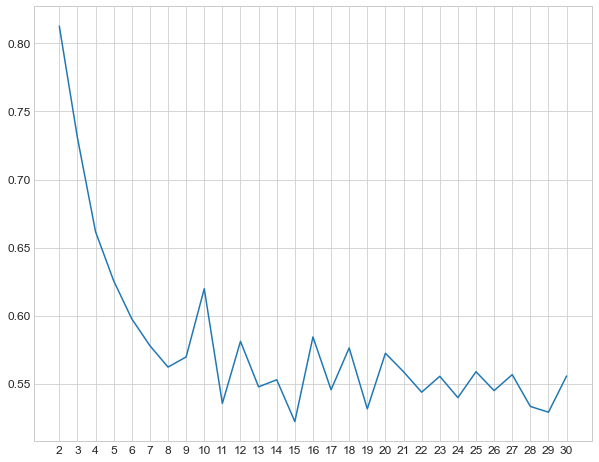

In [41]:
plt.style.use('seaborn-whitegrid')
plt.plot(num_of_topics, coherence) # x-axis = K, y-axis = coherece measures
plt.xticks(num_of_topics) # To label x-axis with K values
plt.show()

In [42]:
lda = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics = 4)
# num_topics：number of topics
# num_words：the number of terms output under each topic

for topic in lda.show_topics(num_words = 5, num_topics = 4):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0:
  "mod" (0.036)
  "support" ( 0.035)
  "help" ( 0.034)
  "report" ( 0.018)
  "bot"( 0.018)
1:
  "car" (0.005)
  "union" ( 0.004)
  "tesla" ( 0.004)
  "model" ( 0.004)
  "drive"( 0.004)
2:
  "car" (0.005)
  "tesla" ( 0.005)
  "model" ( 0.003)
  "s" ( 0.003)
  "drive"( 0.003)
3:
  "car" (0.005)
  "price" ( 0.004)
  "model" ( 0.004)
  "tesla" ( 0.004)
  "s"( 0.004)


In [43]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda, corpus_tfidf, dictionary)
pyLDAvis.display(lda_visualization)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
